## 저장내용 불러오기

In [24]:
import csv
new_t = []
neg = []
pos = []
f = open('elect_training.csv','r',encoding='utf-8-sig')
rdf = csv.reader(f)

for i in rdf:
    if i[1] == '0':
        neg.append(i)
    else:
        pos.append(i)
    new_t.append(i)

print(len(neg[:297]))
print(len(pos))

297
297


In [25]:
training = []
test = []

for i in range(200):
    training.append(pos[i])
    training.append(neg[i])

for j in range(200,297):
    test.append(pos[j])
    test.append(neg[j])

## 광고성리뷰 필터링

In [72]:
#리뷰에 'http'를 포함하는 링크가 있을 시 제외
new_t = filter(lambda i: 'http' not in i[0], new_t)


## 단어 토큰화

In [26]:
from konlpy.tag import Okt
import nltk
import re


okt = Okt()

def modify(text):
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' #한글 자모음 제거
    text = re.sub(pattern=pattern, repl=' ', string=text)
    pattern = '[^\w\s]' #특수기호 제거
    text = re.sub(pattern=pattern, repl=' ', string=text)
    return text

def tokenize(doc):
    return ['/'.join(t) for t in okt.pos(doc,norm=True,stem=True)]



training_r = [(tokenize(modify(row[0])),row[1]) for row in training]#[('단어/형태',...,0 or 1)]
test_r = [(tokenize(modify(row[0])),row[1]) for row in test]#[('단어/형태',...,0 or 1)]
print()
token = [t for d in training_r for t in d[0]] #단어들만 따로 모음

text = nltk.Text(token)
print(text)


<Text: 생각/Noun 보다/Josa 가볍다/Adjective 집/Noun 에서/Josa 쓸다/Verb 만해/Noun 요/Josa...>


## 최빈값 추출 및 단어 빈도 수 저장

In [116]:
import pickle
import os
path = os.getcwd()+'/pickles/'

selected_words = [f[0] for f in text.vocab().most_common(2500)] 

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

with open('reviewSelected2500.p', 'wb') as f:
    pickle.dump(selected_words, f)

## training setting

In [31]:
train_x_temp = [(term_frequency(a),b) for a,b in training_r]
train_sum = [sum(d[0]) for d in train_x_temp]
for i in range(len(train_sum)):
    if train_sum[i] == 0:
        train_sum[i] = 1
        
train_x = []
train_x2 = []    
for d in range(len(train_x_temp)):
    li = [float(l)/train_sum[d] for l in train_x_temp[d][0]]
    train_x.append(li)
    train_x2.append((li,train_x_temp[d][1]))


test_x_temp = [(term_frequency(a),b) for a,b in test_r]
test_sum = [sum(d[0]) for d in test_x_temp]
for i in range(len(test_sum)):
    if test_sum[i] == 0:
        test_sum[i] = 1
        
test_x = []
test_x2 = []    
for d in range(len(test_x_temp)):
    li = [float(l)/test_sum[d] for l in test_x_temp[d][0]]
    test_x.append(li)
    test_x2.append((li,test_x_temp[d][1]))
    
    
train_y = [c for _,c in training_r]
test_y = [c for _,c in test_r]


In [32]:
import numpy as np
x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')
y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

## 학습

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint(filepath='ReviewModel',monitor='val_binary_accuracy',save_best_only=True)]

model = models.Sequential()
model.add(layers.Dense(1200,activation='relu',input_shape=(2500,)))#실제 쓸 단어갯수
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),loss = losses.binary_crossentropy,metrics=[metrics.binary_accuracy])

hist = model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test),callbacks=callbacks)



Epoch 1/50
12/13 [==========================>...] - ETA: 0s - loss: 0.6778 - binary_accuracy: 0.6016WARNING:tensorflow:From /Users/leesangyun/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ReviewModel/assets
13/13 [==============================] - 1s 74ms/step - loss: 0.6774 - binary_accuracy: 0.5950 - val_loss: 0.6411 - val_binary_accuracy: 0.7216
Epoch 2/50
13/13 [==============================] - 1s 75ms/step - loss: 0.5665 - binary_accuracy: 0.8325 - val_loss: 0.5518 - val_binary_accuracy: 0.8247
Epoch 3/50
13/13 [==============================] - 1s 44ms/step - loss: 0.4125 - binary_accuracy: 0.8975 - val_loss: 0.4935 - val_binary_accuracy: 0.7887
Epoch 4/50
13/

13/13 [==============================] - 0s 17ms/step - loss: 0.0085 - binary_accuracy: 0.9975 - val_loss: 1.6115 - val_binary_accuracy: 0.7732
Epoch 50/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0089 - binary_accuracy: 0.9950 - val_loss: 1.6361 - val_binary_accuracy: 0.7732


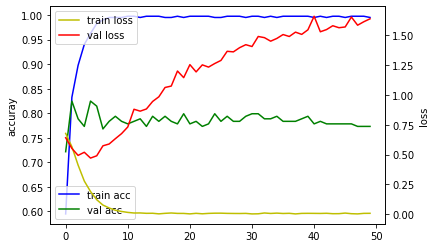

In [40]:
#8
%matplotlib inline
import matplotlib.pyplot as plt

fig, acc_ax = plt.subplots()

loss_ax = acc_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['binary_accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_binary_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [1]:
"""def predict(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'),axis=0)
    score = float(model.predict(data))
    #print(score)
    if(score>0.5):
        #print("[{}]는 {:.2f}%확률로 만족 리뷰입니다.".format(review,score*100))
        return score
    else:
        #print("[{}]는 {:.2f}%확률로 불만족 리뷰입니다.".format(review,(1-score)*100))
        return -(1-score)"""

In [114]:
def keyword_predict(s):
    test_t = tokenize(s)
    tf = term_frequency(test_t)
    tf_sum = 0
    for i in tf:
        tf_sum = tf_sum + i
    if tf_sum == 0:
        tf_sum = 1
    final_tf = [i/tf_sum for i in tf]
    data = np.expand_dims(np.asarray(final_tf).astype('float32'),axis=0)
    score = float(model_best.predict(data))
    #print(score)

    if(score>0.55):
        #print("[{}]는 {:.2f}%확률로 만족 리뷰입니다.".format(s,score*100))
        return score
    elif(score<0.45):
        #print("[{}]는 {:.2f}%확률로 불만족 리뷰입니다.".format(s,(1-score)*100))
        return -(1-score)
    else:
        #print('그저 그렇다')
        return 0
    
keyword_predict('성능이 안좋다')

-0.6199873685836792

In [46]:
#모델 로컬에 저장
model_best = models.load_model('ReviewModel')
def predict(x):
    data = np.expand_dims(np.asarray(x).astype('float32'),axis=0)
    score = model_best.predict(data)
    if(score>0.5):
        return 1
    else:
        return 0

In [104]:
# 테스트 데이터 정확도
count = 0
for i in test_x2:
    if predict(i[0]) == int(i[1]):
        count = count + 1
print(count/len(test_r))

0.8247422680412371


## 키워드별 스코어의 가중평균

In [ ]:
import pandas as pd
# dataframe으로 변형하기 전에 last_table에 각 제품별로 리뷰 수를 나타내는 컬럼을 마지막에 추가해놔야한다.
score_df = pd.DataFrame(last_table, columns=['item', '가성비', 'as', '배송', '성능', 'count']
score_df


In [ ]:
C = score_df.mean()[0:4] # 전체 평균 평점
m = 50 # 분석을 하기 위한 최소 리뷰 수

def weighted_score(score):
    v = score['count'] # 개별 댓글 개수
    R = score[1:5] # 개별 평균 평점

    return ((v/(v+m)) * R) + ((m/(m+v)) * C)
score_df.apply(weighted_score, axis=1)
